Missing values per column:
 age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64


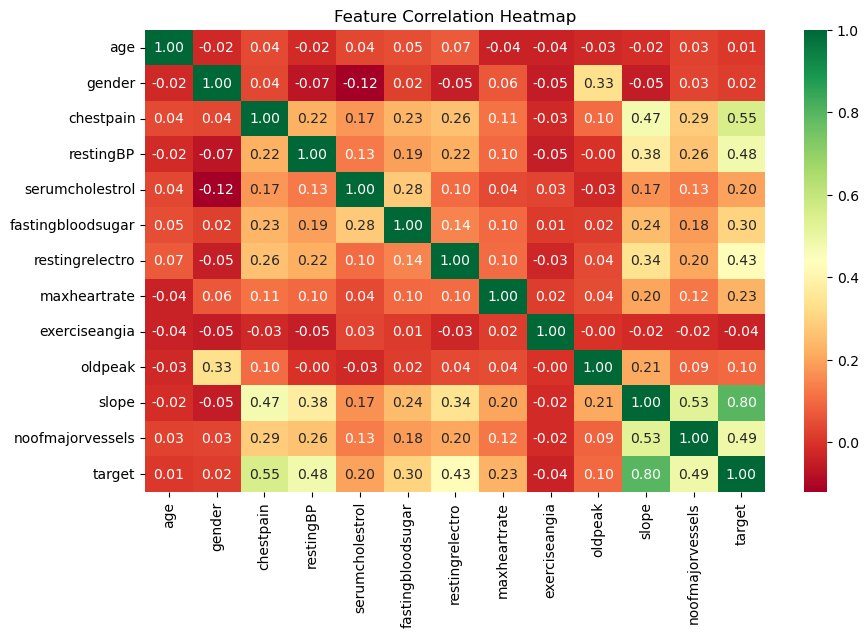

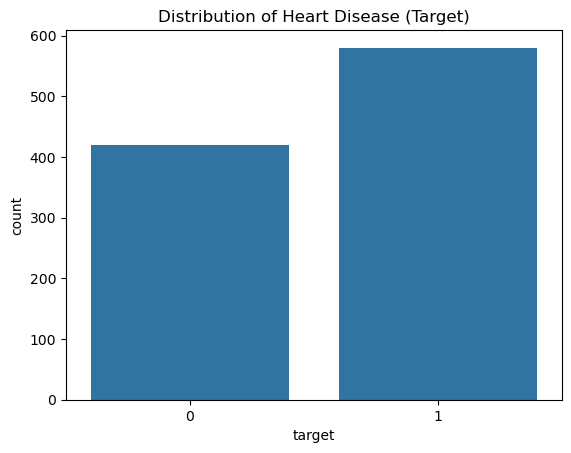

Balanced Target Counts:
 target
0    420
1    420
Name: count, dtype: int64


C:\Users\Rizwan computers\AppData\Local\Temp\ipykernel_14352\1250648356.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


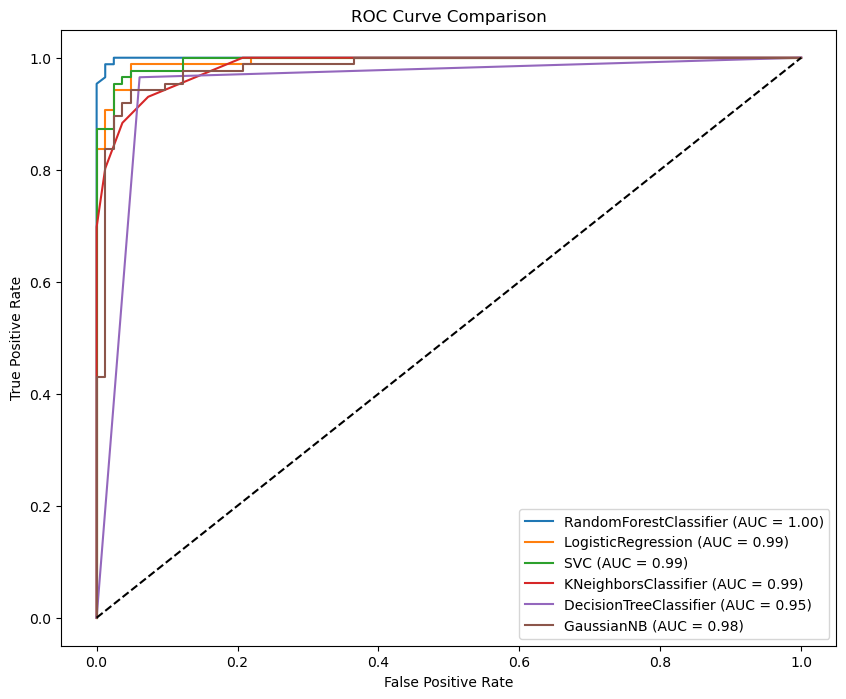


Model Comparison Table:
                    Model  Accuracy  F1-Score  Precision    Recall
0  RandomForestClassifier  0.988095  0.988095   0.988095  0.988095
1      LogisticRegression  0.952381  0.952381   0.952381  0.952381
2                     SVC  0.964286  0.964291   0.964569  0.964286
3    KNeighborsClassifier  0.922619  0.922561   0.925718  0.922619
4  DecisionTreeClassifier  0.952381  0.952361   0.952611  0.952381
5              GaussianNB  0.928571  0.928541   0.928774  0.928571


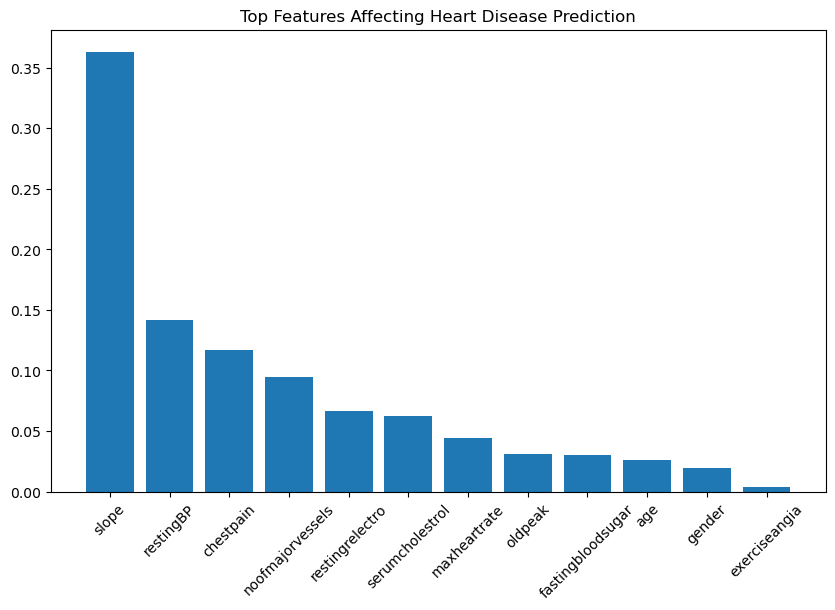


--- Individual Prediction Test ---
Predicted class: 1
Actual class: 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# --- 1. DATA LOADING & CLEANING ---
df = pd.read_csv(r'C:\Users\Rizwan computers\Documents\heart_disease_dataset.csv')
if 'patientid' in df.columns:
    df.drop('patientid', axis=1, inplace=True)

# Check for missing values (Requirement: Handle missing values)
print("Missing values per column:\n", df.isnull().sum())

# --- 2. EXPLORATORY DATA ANALYSIS (EDA) ---
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Distribution of Target

sns.countplot(x='target', data=df)
plt.title("Distribution of Heart Disease (Target)")
plt.show()

# --- 3. HANDLING CLASS IMBALANCE ---
# Separate majority and minority classes
df_majority = df[df.target == 0]
df_minority = df[df.target == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),    
                                 random_state=42) 

df_balanced = pd.concat([df_majority, df_minority_upsampled])
print("Balanced Target Counts:\n", df_balanced['target'].value_counts())

# --- 4. PREPROCESSING ---
X = df_balanced.drop('target', axis=1)
y = df_balanced['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform, not fit_transform here

# --- 5. MODEL TRAINING & COMPARISON ---
classifiers = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(),
    SVC(probability=True), # probability=True is needed for ROC curve
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    GaussianNB()
]

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall'])

plt.figure(figsize=(10, 8)) # Setup for ROC Plot

for clf in classifiers:
    clf_name = clf.__class__.__name__
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    new_row = pd.DataFrame([{
        'Model': clf_name,
        'Accuracy': acc,
        'F1-Score': report['weighted avg']['f1-score'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall']
    }])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # ROC Curve Data
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Finalize ROC Plot

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print("\nModel Comparison Table:")
print(results_df)

# --- 6. FEATURE IMPORTANCE (Using Random Forest) ---
# Requirement: Highlight important features
rf_model = classifiers[0] # RandomForest is first in list
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10, 6))
plt.title("Top Features Affecting Heart Disease Prediction")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.show()

# --- 7. INDIVIDUAL PREDICTION TEST ---
print("\n--- Individual Prediction Test ---")
test_sample = X_test_scaled[0].reshape(1, -1)
print(f"Predicted class: {rf_model.predict(test_sample)[0]}")
print(f"Actual class: {y_test.iloc[0]}")